In [145]:
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

In [146]:
files = listdir('messages/')

messages = []

for filename in files:
    is_legit = filename.find('legit') != -1
    is_spam = filename.find('spmsg') != -1

    if is_legit != is_spam:
        with open('messages/' + filename, 'r') as fin:
            message = []
            for line in fin.readlines():
                message.append(line[:-1])

            messages.append({
                'legit': is_legit,
                'message': message
            })

In [147]:
def append_val(r, c, v, row, col, val, nrow, ncol):
    row.append(r)
    col.append(c)
    val.append(v)

    nrow = max(nrow, r + 1)
    ncol = max(ncol, c + 1)

    return (row, col, val, nrow, ncol)

def parse_data(should_separate, mode, msgs):
    row = []
    col = []
    val = []
    target = []

    nrow = 0
    ncol = 0

    word_to_id = {}
    free_id = 0

    for text_id, msg in enumerate(msgs):
        target.append(1 if msg['legit'] else 0)

        occurences = {}
        occurences_in_subject = {}

        for line in msg['message']:
            if len(line) == 0:
                continue

            words = line.split()
            if words[0] == 'Subject:':
                for word in words[1:]:
                    num_word = int(word)
                    if num_word not in word_to_id:
                        word_to_id[num_word] = free_id
                        free_id += 1

                    id = word_to_id[num_word]

                    if should_separate:
                        occurences_in_subject[id] = occurences_in_subject.get(id, 0) + 1
                    else:
                        occurences[id] = occurences.get(id, 0) + 1
            else:
                for word in words:
                    num_word = int(word)
                    if num_word not in word_to_id:
                        word_to_id[num_word] = free_id
                        free_id += 1

                    id = word_to_id[num_word]

                    occurences[id] = occurences.get(id, 0) + 1
            
        
            for id_col, cnt_occurences in occurences.items():
                if mode == 'cnt':
                    row, col, val, nrow, ncol = append_val(text_id, id_col, cnt_occurences, row, col, val, nrow, ncol)
                elif mode == 'has':
                    row, col, val, nrow, ncol = append_val(text_id, id_col, 1, row, col, val, nrow, ncol)

            shift = len(word_to_id.keys())

            for id_col, cnt_occurences in occurences_in_subject.items():
                if mode == 'cnt':
                    row, col, val, nrow, ncol = append_val(text_id, id_col + shift, cnt_occurences, row, col, val, nrow, ncol)
                elif mode == 'has':
                    row, col, val, nrow, ncol = append_val(text_id, id_col + shift, 1, row, col, val, nrow, ncol)

    return csr_matrix((np.array(val), (np.array(row), np.array(col))), shape=(nrow, ncol), dtype=int).toarray(), np.array(target)

Теорема Байеса: $P(A|B) = \dfrac{P(B|A)P(A)}{P(B)}$<br>

$P(A|B)$ - апостериорная вероятность класса<br>
$P(A)$ - априорная вероятность класса<br>
$P(B|A)$ - правдоподобие (вероятность значения признака В при классе А)<br>
$P(B)$ - априорная вероятность значения признака В<br>

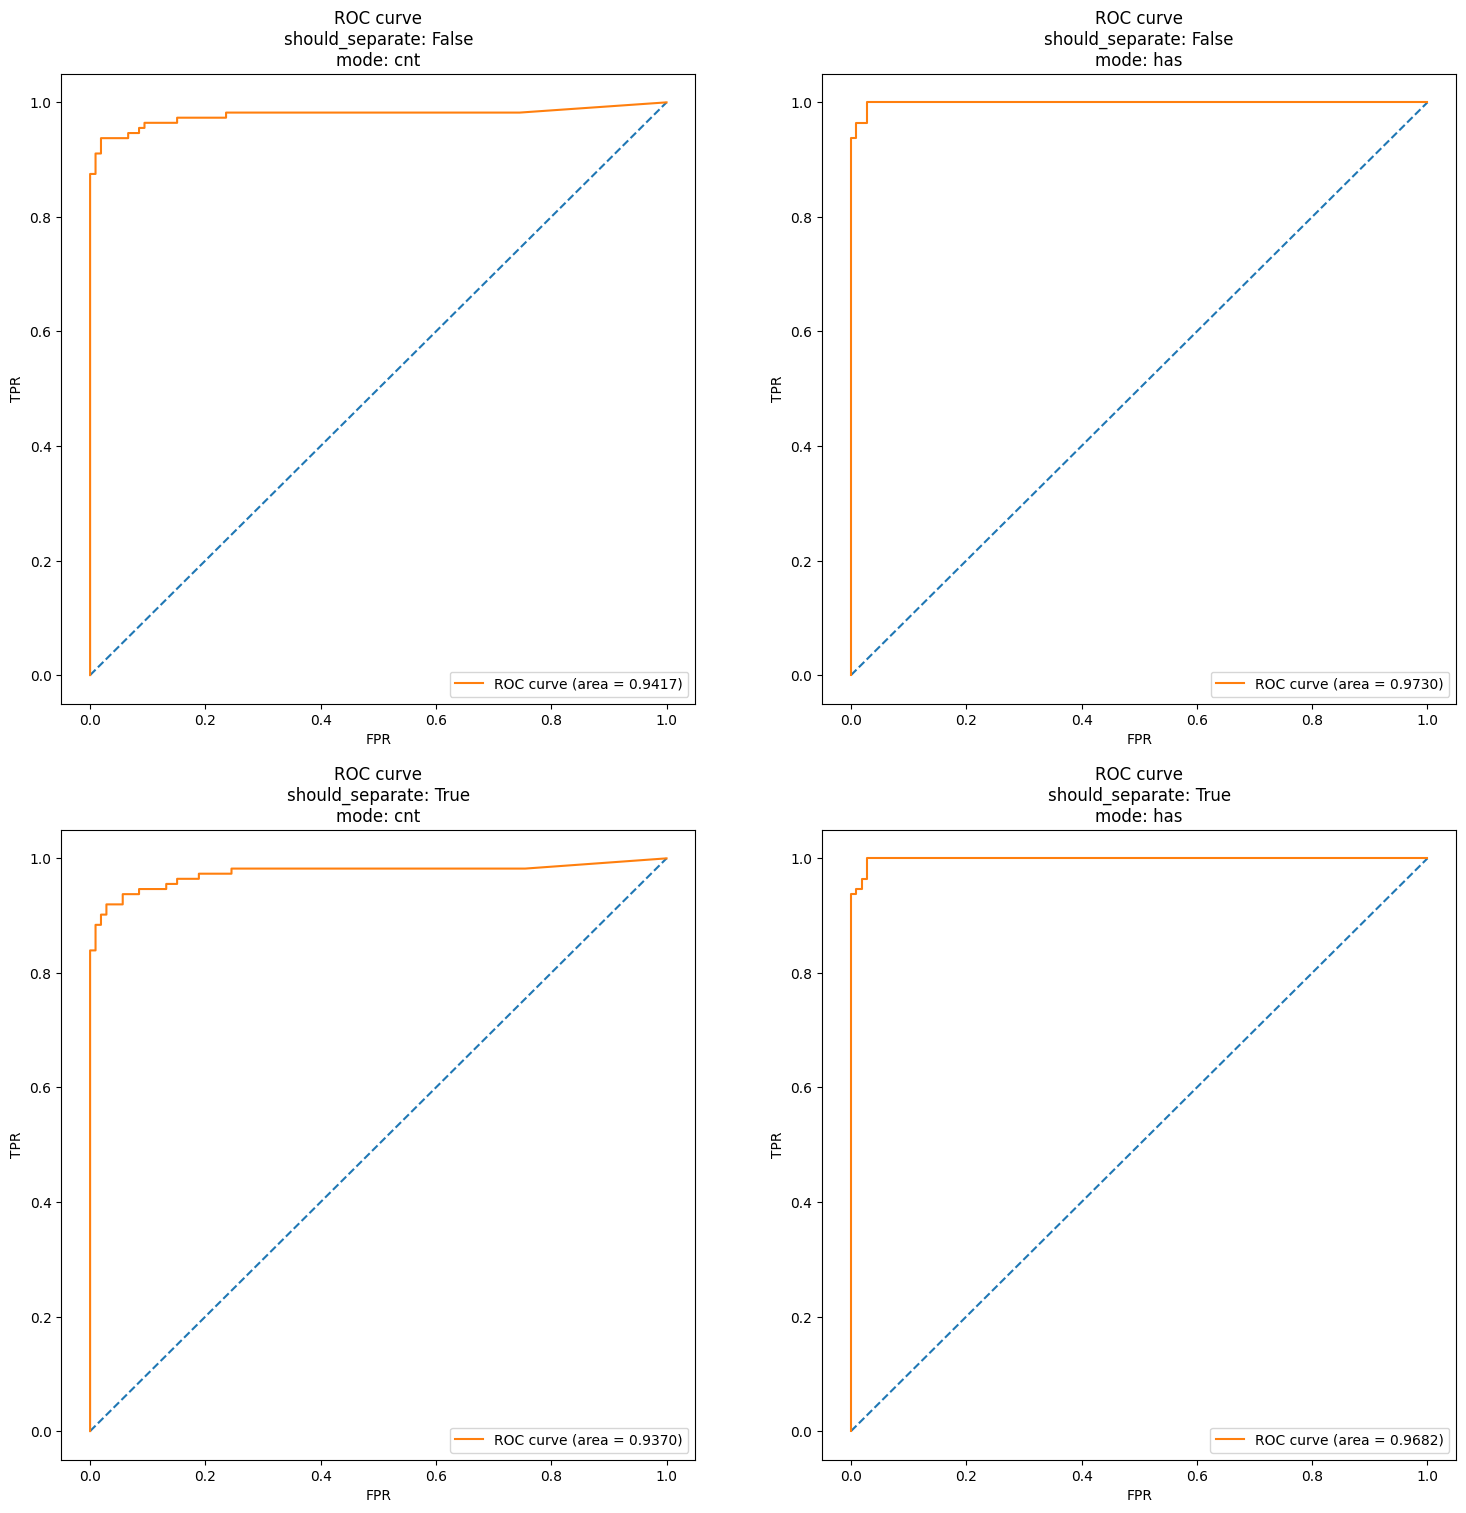

In [157]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 18))

for i, should_separate in enumerate([False, True]):
    for j, mode in enumerate(['cnt', 'has']):
        msgs_table, target = parse_data(should_separate, mode, messages)
        
        train, test, train_target, test_target = train_test_split(msgs_table, target, test_size=0.2, random_state=0)

        model = MultinomialNB()
        model.fit(train, train_target)
        prediction = model.predict_proba(test)
        pred = model.predict(test)

        fpr, tpr, thresholds = roc_curve(test_target, prediction[:, 1])
        area = "{:.4f}".format(roc_auc_score(test_target, pred))

        ax[i][j].plot([0, 1], [0, 1], linestyle='--')
        ax[i][j].plot(fpr, tpr, label=f'ROC curve (area = {area})')
        ax[i][j].set_title(f'ROC curve\nshould_separate: {should_separate}\nmode: {mode}')
        ax[i][j].set_ylabel('TPR')
        ax[i][j].set_xlabel('FPR')
        ax[i][j].legend(loc='lower right')

plt.show()

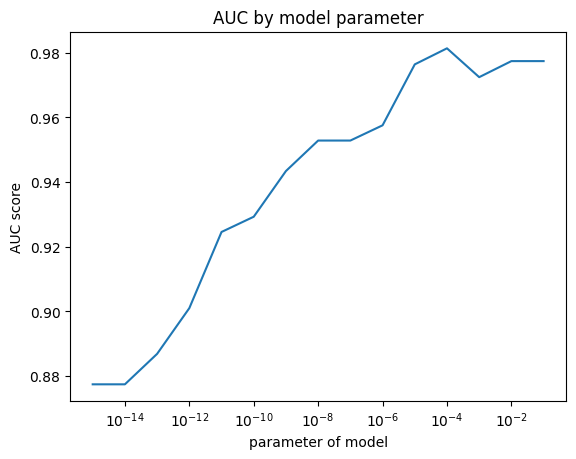

In [161]:
should_separate = False
mode = 'has'

msgs_table, target = parse_data(should_separate, mode, messages)
train, test, train_target, test_target = train_test_split(msgs_table, target, test_size=0.2, random_state=0)

aucs = []
ps = []

for pw in range(-15, 0):
    p = 10 ** pw
    ps.append(p)
    model = MultinomialNB(fit_prior=False, class_prior=[p, 1 - p])
    model.fit(train, train_target)
    prediction = model.predict(test)
    fpr, tpr, thresholds = roc_curve(test_target, prediction)
    aucs.append(roc_auc_score(test_target, prediction))

plt.xscale('log')
plt.plot(ps, aucs)
plt.ylabel('AUC score')
plt.xlabel('parameter of model')
plt.title('AUC by model parameter')
plt.show()

0.9575471698113208
0.9622641509433962
0.9669811320754718
0.9716981132075472
0.9811320754716981
0.9811320754716981
0.9813847708894878
0.9813847708894878
0.9813847708894878
0.9724561994609164
0.9724561994609164
0.9724561994609164
0.9727088948787063
0.9774258760107818
0.9774258760107818
0.9774258760107818
0.9774258760107818


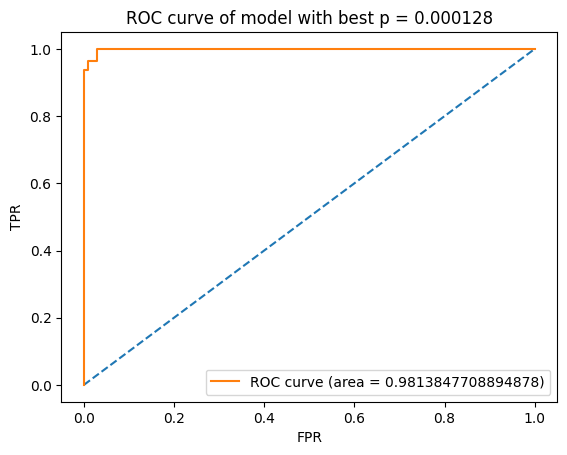

In [156]:
p = 10 ** -6

best_p = 0
best_fpr = 0
best_tpr = 0
best_auc = 0

while p < 0.1:
    model = MultinomialNB(fit_prior=False, class_prior=[p, 1 - p])
    model.fit(train, train_target)
    prediction = model.predict_proba(test)
    pred = model.predict(test)
    fpr, tpr, thresholds = roc_curve(test_target, prediction[:, 1])
    auc = roc_auc_score(test_target, pred)
    print(auc)
    p *= 2

    if auc > best_auc:
        best_auc = auc
        best_p = p
        best_fpr = fpr
        best_tpr = tpr

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(best_fpr, best_tpr, label=f'ROC curve (area = {best_auc})')
plt.title(f'ROC curve of model with best p = {best_p}')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.legend(loc='lower right')
plt.show()